This plot a bubble map in Plotly to mimic the 'Bubble Map' D3.js visualization, involving mapping data points (in this case, Bigfoot sightings) onto a geographical map, where the size of each bubble corresponds to the number of sightings in that area. Plotly's scatter_geo function can plot latitude and longitude points on a map and adjust the marker size to represent an additional dimension of the data (like population in the D3.js example, or SightingsCount in your Bigfoot sightings data).

In [1]:
import pandas as pd
import plotly.express as px

# Load and prepare data
data_path = 'https://raw.githubusercontent.com/nguyenlamvu88/dsci550_assignment_3_visualizations/main/jupyter_data/reduced_bigfoot_sightings.json'
df = pd.read_json(data_path)

# Convert 'Date' to datetime, extract year, and convert necessary columns to numeric types
df['Date'] = pd.to_datetime(df['Date'])
df['Illumination'] = pd.to_numeric(df['Illumination'], errors='coerce')
df['Distance (km)'] = pd.to_numeric(df['Distance (km)'], errors='coerce')
df['Moon Phase'] = pd.to_numeric(df['Moon Phase'], errors='coerce')

# Calculate SightingsCount per county (assuming this field represents a count of sightings)
df['SightingsCount'] = df.groupby(['State', 'County'])['County'].transform('count')

# Construct a radius scale based on SightingsCount, similar to the D3.js example
# Here, we'll use the size parameter of scatter_geo to simulate this effect
max_sightings = df['SightingsCount'].max()
df['ScaledSightings'] = df['SightingsCount'] / max_sightings * 40  # Scale sightings

fig = px.scatter_geo(df,
                     lat='Geo Lucence Latitude',
                     lon='Geo Lucence Longitude',
                     size='ScaledSightings',
                     hover_name='County',
                     hover_data=['State', 'SightingsCount'],
                     title='Geographical Distribution of Bigfoot Sightings Across the U.S.',
                     scope='usa',  # Automatically focuses the map on the USA
                     projection='albers usa',  # Uses the Albers projection, common for US maps
                     color='SightingsCount',
                     color_continuous_scale=px.colors.sequential.Plasma)
fig.update_geos(
    landcolor='Gray',
    oceancolor='LightBlue',
    showocean=True,
    lakecolor='LightBlue'
)
fig.show()
fig.write_html("sightings_heatmap.html")


This code will display a stacked bar chart where each stack segment represents sightings in one of the primary moon phase categories. It allows you to compare the number of sightings during different moon phases (New Moon, First Quarter, Full Moon, Last Quarter) for each year. The categorize_moon_phase function can be adjusted based on how your moon phase data is structured. Used template from D3 'Revenue by music format, 1973–2018'

In [3]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Load the dataset and create the DataFrame
df = pd.read_json('https://raw.githubusercontent.com/nguyenlamvu88/dsci550_assignment_3_visualizations/main/jupyter_data/reduced_bigfoot_sightings.json')

# Convert 'Date' to datetime and extract year for temporal aggregation
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year

# Convert 'Moon Phase' to numeric and categorize moon phases
df['Moon Phase'] = pd.to_numeric(df['Moon Phase'])
def categorize_moon_phase(phase):
    if 0 <= phase < 0.125 or 0.875 <= phase <= 1:
        return 'New Moon'
    elif 0.125 <= phase < 0.375:
        return 'First Quarter'
    elif 0.375 <= phase < 0.625:
        return 'Full Moon'
    elif 0.625 <= phase < 0.875:
        return 'Last Quarter'
    else:
        return 'Unknown'  # For any unexpected case

df['Moon Phase Category'] = df['Moon Phase'].apply(categorize_moon_phase)

# Group by Year and Moon Phase Category, then count the sightings
pivot_df = df.groupby(['Year', 'Moon Phase Category']).size().unstack(fill_value=0)

# Continue with the visualization...

# Aggregate total sightings by year for the line trace
total_sightings_by_year = df.groupby('Year').size().reset_index(name='TotalSightings')

# Define contrasting colors for the moon phase categories
contrasting_colors = ['#17becf', '#bcbd22', '#7f7f7f', '#e377c2']

# Create a figure with secondary y-axis for the bar and line chart
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add a bar trace for each moon phase category in the pivoted DataFrame with contrasting colors
for index, category in enumerate(pivot_df.columns):
    fig.add_trace(
        go.Bar(x=pivot_df.index, y=pivot_df[category], name=category,
               marker_color=contrasting_colors[index % len(contrasting_colors)])
    )

# Add the line trace for total yearly sightings with a distinct contrasting color
fig.add_trace(
    go.Scatter(x=total_sightings_by_year['Year'], y=total_sightings_by_year['TotalSightings'],
               mode='lines+markers', name='Total Sightings', line=dict(color='dark green', width=1.5)),
    secondary_y=False,
)

# Update layout for stacked bar chart and line trace
fig.update_layout(
    barmode='stack',
    title='Bigfoot Sightings Over Time by Moon Phase with Total Count',
    xaxis=dict(showline=True, showgrid=False, showticklabels=True,
               linecolor='rgb(204, 204, 204)', linewidth=2,
               ticks='outside', tickfont=dict(family='Arial', size=12, color='rgb(82, 82, 82)')),
    yaxis=dict(title='Number of Sightings', showgrid=False, zeroline=False, showline=False, showticklabels=True),
    plot_bgcolor='white',
    autosize=True,
    margin=dict(autoexpand=True, l=100, r=20, t=110),
    showlegend=True,
)

# Customize the axes to match the D3.js example as close as possible
fig.update_xaxes(title_text='Year')
fig.update_yaxes(title_text='Number of Sightings', secondary_y=False)

# Show the figure
fig.show()
fig.write_html("sightings_moonphases.html")


This visualzation plots the national parks as points and then scatter sightings around them, coloring the sightings based on the distance from the nearest national park to see if there's a pattern indicating that sightings are more common near these parks.

In [4]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Load the dataset
data_path = 'https://raw.githubusercontent.com/nguyenlamvu88/dsci550_assignment_3_visualizations/main/jupyter_data/reduced_bigfoot_sightings.json'
df = pd.read_json(data_path)

# Convert 'Illumination' to a numeric type, if it's not already
df['Illumination'] = pd.to_numeric(df['Illumination'], errors='coerce')

# Define bins for 'Low', 'Medium', and 'High' illumination categories
bins = [-0.01, 0.33, 0.66, 1]
labels = ['Low', 'Medium', 'High']
df['Illumination Category'] = pd.cut(df['Illumination'], bins=bins, labels=labels, include_lowest=True)

# Get the counts for each category
category_counts = df['Illumination Category'].value_counts().sort_index()

# Create the strip plot
fig = px.strip(df, x='Illumination Category', y='Illumination', color='Illumination Category',
               title='Bigfoot Sightings by Moon Illumination Category',
               labels={'Illumination': 'Moon Illumination (%)'})

# Add total counts as annotations on the strip plot
for i, category in enumerate(category_counts.index):
    fig.add_annotation(
        x=category,
        y=1.02,  # slightly above the strips
        text=f"Total: {category_counts[category]}",
        showarrow=False,
        yref="paper",
        xref="x",
        align="center"
    )

# Customize the layout to ensure the annotation text is visible
fig.update_layout(
    yaxis_range=[-0.1,1.1]  # Increase y-axis range to create space for the annotations
)

# Show the plot
fig.show()


This map visualize the number of sightings based on their distance from the nearest national park.

In [15]:
import pandas as pd
import plotly.graph_objects as go

# Load the dataset
data_path = 'https://raw.githubusercontent.com/nguyenlamvu88/dsci550_assignment_3_visualizations/main/jupyter_data/reduced_bigfoot_sightings.json'
df = pd.read_json(data_path)

# Extracting unique national parks
national_parks = df[['Closest National Park', 'Geo Lucence Latitude', 'Geo Lucence Longitude']].drop_duplicates('Closest National Park')

# Manually set symbols
symbol = 'diamond'
national_parks['Symbol'] = symbol

# Initialize a figure
fig = go.Figure()

# Plot sightings - adjusting color and size
fig.add_trace(go.Scattergeo(
    lon = df['Geo Lucence Longitude'],
    lat = df['Geo Lucence Latitude'],
    mode = 'markers',
    marker = dict(
        size = 4,  # Reduced size for sightings
        color = 'orange',  # Changed color to orange
    ),
    name = 'Sightings'
))

# Add each national park with a unique symbol
for _, row in national_parks.iterrows():
    fig.add_trace(go.Scattergeo(
        lon = [row['Geo Lucence Longitude']],
        lat = [row['Geo Lucence Latitude']],
        text = row['Closest National Park'],
        mode = 'markers',
        marker = dict(
            size = 8,
            symbol = row['Symbol'],
            color = 'green',
        ),
        name = row['Closest National Park'],
        textposition = "bottom center"
    ))

# Update the layout
fig.update_layout(
    title = 'Bigfoot Sightings by Proximity to National Parks',
    geo = dict(
        scope = 'usa',
        landcolor = 'rgb(217, 217, 217)',
    ),
    showlegend = True
)

# Show the plot
fig.show()

This script is an enhance version from the above using a Mapbox base map which includes terrain features to highlights the habitation of BigFoot

In [6]:
import pandas as pd
import plotly.graph_objects as go

# Your Mapbox access token
mapbox_access_token = 'pk.eyJ1Ijoibmd1eWVubGFtdnU4OCIsImEiOiJjbHVoenF4bGUydWZqMmlwOXU3bHI5dG80In0.HE4Sg7BQFfgDjrMiGOviPg'

# Load the dataset
data_path = 'https://raw.githubusercontent.com/nguyenlamvu88/dsci550_assignment_3_visualizations/main/jupyter_data/reduced_bigfoot_sightings.json'
df = pd.read_json(data_path)

# Extracting unique national parks
national_parks = df[['Closest National Park', 'Geo Lucence Latitude', 'Geo Lucence Longitude']].drop_duplicates('Closest National Park')

# Manually set symbols
symbol = 'park'
national_parks['Symbol'] = symbol

# Initialize a figure
fig = go.Figure()

# Plot sightings - adjusting color and size
fig.add_trace(go.Scattermapbox(
    lon = df['Geo Lucence Longitude'],
    lat = df['Geo Lucence Latitude'],
    mode = 'markers',
    marker = dict(
        size = 4,  # Reduced size for sightings
        color = 'orange',  # Changed color to orange
    ),
    name = 'Sightings'
))

# Add each national park with a unique symbol
for _, row in national_parks.iterrows():
    fig.add_trace(go.Scattermapbox(
        lon = [row['Geo Lucence Longitude']],
        lat = [row['Geo Lucence Latitude']],
        text = row['Closest National Park'],
        mode = 'markers',
        marker = dict(
            size = 8,
            symbol = row['Symbol'],
            color = 'green',
        ),
        name = row['Closest National Park'],
        textposition = "bottom center"
    ))

# Update the layout to use Mapbox with terrain features
fig.update_layout(
    title = 'Mapbox Bigfoot Sightings by Proximity to National Parks',
    mapbox = dict(
        accesstoken = mapbox_access_token,
        bearing = 0,
        center = go.layout.mapbox.Center(lat = 38, lon = -94),  # Center map on the US
        pitch = 0,
        zoom = 3,
        style = 'mapbox://styles/mapbox/outdoors-v11'  # Using the "outdoors" style for terrain
    ),
    showlegend = True
)

# Show the plot
fig.show()
fig.write_html("sightings_terrain_features.html")


count    5256.000000
mean       -0.175957
std         0.110426
min        -0.466667
25%        -0.250000
50%        -0.166667
75%        -0.125000
max         0.245489
Name: Sentiment, dtype: float64


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


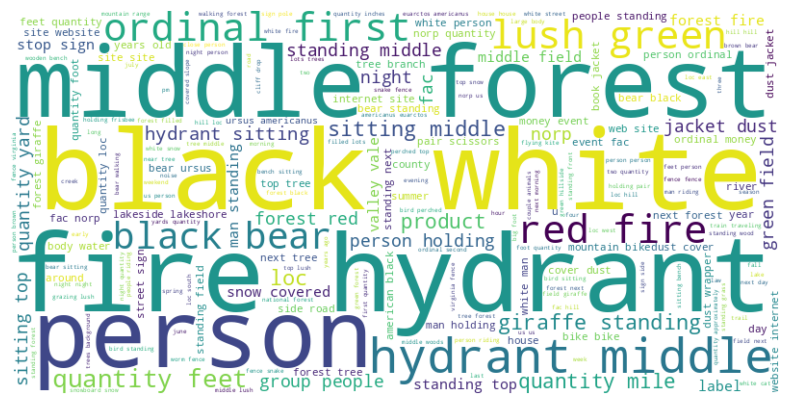

In [10]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/nguyenlamvu88/dsci550_assignment_3_visualizations/main/jupyter_data/assignment_2_final_dataset_csv.csv')

# Filtering out NaN values from the columns of interest
df_filtered = df[['Tika Caption', 'Tika Classification', 'Spacy Entities']].dropna()

# Perform sentiment analysis only on 'Tika Caption'
df_filtered['Sentiment'] = df_filtered['Tika Caption'].apply(lambda x: TextBlob(x).sentiment.polarity)
print(df_filtered['Sentiment'].describe())

# Setup for keyword extraction including stopwords
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
# Defining NER-related and additional stopwords to exclude
ner_related_stopwords = {'score', 'date', 'cardinal', 'confidence', 'sentence', 'text', 'time', 'org', 'gpe'}
additional_stopwords = {'bigfoot', 'sighting', 'report', 'said', 'one', 'saw', 'area', 'units', 'ms', 'captioning', 'read', 'nan', 'captions','photo'}
all_stopwords = stop_words.union(additional_stopwords, ner_related_stopwords)

# Combine text from 'Tika Caption', 'Tika Classification', and 'Spacy Entities', excluding specific stopwords
combined_text = ' '.join(df_filtered['Tika Caption'] + ' ' + df_filtered['Tika Classification'] + ' ' + df_filtered['Spacy Entities'])

# Tokenize words and remove stopwords from the combined text
words = [word for word in word_tokenize(combined_text.lower()) if word.isalpha() and word not in all_stopwords]

# Prepare data for word cloud
wordcloud_text = ' '.join(words)

# Generate and display the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(wordcloud_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


This script creates a basic text scatter plot, word cloud-like visualization for the top 95 words (excluding column names and texts described the entities such PLACE or ORG) using Plotly. The np.random.rand() functions are placeholders for the x and y positions of each word, creating a random layout where each word's size is proportional to its frequency in the dataset.

In [7]:
import pandas as pd
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import plotly.graph_objs as go
import numpy as np

# Load the dataset from a JSON file
df = pd.read_json('https://raw.githubusercontent.com/nguyenlamvu88/dsci550_assignment_3_visualizations/main/jupyter_data/sentiment_json.json')

# Filter out NaN values
df_filtered = df[['Tika Caption', 'Tika Classification', 'Spacy Entities']].dropna()

# Perform sentiment analysis
df_filtered['Sentiment'] = df_filtered['Tika Caption'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Setup for keyword extraction, including stopwords
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
ner_related_stopwords = {'score', 'date', 'cardinal', 'confidence', 'sentence', 'text', 'time', 'org', 'gpe'}
additional_stopwords = {'bigfoot', 'sighting', 'report', 'said', 'one', 'saw', 'area', 'units', 'ms', 'captioning', 'read', 'nan',
                        'captions', 'photo', 'loc', 'ordinal', 'person', 'quantity', 'norp', 'fac',' '}
all_stopwords = stop_words.union(additional_stopwords, ner_related_stopwords)

combined_text = ' '.join(df_filtered['Tika Caption'] + ' ' + df_filtered['Tika Classification'] + ' ' + df_filtered['Spacy Entities'])
words = [word for word in word_tokenize(combined_text.lower()) if word.isalpha() and word not in all_stopwords]

# Count word frequencies
word_counts = Counter(words)

# Select the top 95 words
top_n = 95  # For example, the top 95 words
top_words = word_counts.most_common(top_n)
word_frequencies = np.array([freq for _, freq in top_words])
scaled_sizes = (word_frequencies - min(word_frequencies)) / (max(word_frequencies) - min(word_frequencies))
word_sizes = scaled_sizes * 30 + 10  # Scale sizes between 10 and 40

# Assign a color to words based on their frequency
colors = px.colors.sequential.Viridis[::-1]  # Reverse the color scale for better visibility
word_colors = [colors[int(size)] for size in scaled_sizes * (len(colors) - 1)]

# Create a scatter plot for the word cloud with Plotly
fig = go.Figure()

# Improved positioning of words to avoid overlap (still not perfect)
x_pos = np.linspace(start=0, stop=1, num=int(np.sqrt(top_n)))
y_pos = np.linspace(start=0, stop=1, num=int(np.sqrt(top_n)))
positions = [(x, y) for x in x_pos for y in y_pos]

for (word, _), size, color, (x, y) in zip(top_words, word_sizes, word_colors, positions):
    fig.add_trace(go.Scatter(
        x=[x],
        y=[y],
        text=[word],
        mode="text",
        textfont={'size': size, 'color': color},
        textposition="middle center"
    ))

fig.update_layout({
    'xaxis': {'showgrid': False, 'showticklabels': False, 'zeroline': False},
    'yaxis': {'showgrid': False, 'showticklabels': False, 'zeroline': False},
    'plot_bgcolor': 'white',
    'margin': {'l': 10, 'r': 10, 't': 10, 'b': 10},
    'showlegend': False,
}),


fig.show()
fig.write_html("entities_wordcloud.html")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


This Python code achieves the following tasks:

Filter sightings within 50 km of national parks.

Summarize entity scores for PRODUCT, GPE, ORG, LOC, and NORP to identify common mentions and their confidence levels near national parks.

Analyze and compare these scores to understand their prominence in sightings near versus far from national parks.

In [9]:
import pandas as pd

# Load the dataset
file_path = 'https://raw.githubusercontent.com/nguyenlamvu88/dsci550_assignment_3_visualizations/main/jupyter_data/assignment_2_final_dataset_csv.csv'
dataset = pd.read_csv(file_path)

# Filter sightings within 50 km of national parks
sightings_near_parks = dataset[dataset['Distance (km)'] <= 50]

# Summarize entity scores
# Counts of non-null mentions for each entity type
entity_types = ['PRODUCT', 'GPE', 'ORG', 'LOC', 'NORP']
counts = {entity: sightings_near_parks[f'{entity} text'].notnull().sum() for entity in entity_types}

# Calculating mean scores for each entity type
mean_scores = {entity: sightings_near_parks[f'{entity}score'].mean() for entity in entity_types}

# Display the counts and mean scores for each entity type
print("Counts of Sightings Mentioning Entities Near Parks:", counts)
print("Mean Scores for Entities Near Parks:", mean_scores)


Counts of Sightings Mentioning Entities Near Parks: {'PRODUCT': 101, 'GPE': 404, 'ORG': 505, 'LOC': 283, 'NORP': 198}
Mean Scores for Entities Near Parks: {'PRODUCT': 0.23890495049504953, 'GPE': 0.3542124301675978, 'ORG': 0.08924039167686659, 'LOC': 0.16848302521008404, 'NORP': 0.07699254901960784}


These visualizations will help illustrate the findings, showing how the type and frequency of entity mentions vary with the proximity to national parks.
- Categorize Sightings: Add a column to categorize sightings based on a predefined distance threshold.
- Calculate Counts and Mean Scores: For each entity type, calculate the count and mean score for sightings near and far from national parks.
- Plot the Data: Generate bar plots to visualize the count of entity mentions and scatter plots for mean scores, comparing near vs. far sightings.

Plotly doesn’t support packed bubble charts directly, but it does support treemaps, which can visualize hierarchical data. Below is a code example that demonstrates how to create a treemap in Plotly.

- Hierarchical structure: outer rectangles representing national parks and inner rectangles representing states that are near those national parks.

- Box size: Each rectangle's size in the treemap represents the proportion of the total value of witness count it holds.

- Color: The color of each rectangle represents the witness count, providing a visual representation of this metric.

In [11]:
import pandas as pd
import plotly.express as px

# Load your dataset
dataset_path = 'https://raw.githubusercontent.com/nguyenlamvu88/dsci550_assignment_3_visualizations/main/jupyter_data/entities_distribution_dataset.json'
data = pd.read_json(dataset_path)

# Group the data by 'Closest National Park' and 'State', and sum the 'Witness Count'
grouped_data = data.groupby(['Closest National Park', 'State'])['Witness Count'].sum().reset_index()

# Filter out the entries with a 'Witness Count' of zero
grouped_data = grouped_data[grouped_data['Witness Count'] > 0]

# Create the treemap using an aesthetically appealing color scale
fig = px.treemap(grouped_data, path=['Closest National Park', 'State'], values='Witness Count',
                 color='Witness Count', hover_data=['Closest National Park', 'State'],
                 color_continuous_scale='Viridis', range_color=[grouped_data['Witness Count'].min(), grouped_data['Witness Count'].max()])  # Setting the color scale range

# Update the layout to adjust the color bar
fig.update_layout(
    coloraxis_colorbar=dict(
        title='Witness Count',
        tickvals=[grouped_data['Witness Count'].min(), grouped_data['Witness Count'].max()],
        ticktext=['Fewer Witnesses', 'More Witnesses']
    )
)

# Show the figure
fig.show()
fig.write_html("witness_count_squares.html")

this code is used for analyzing and visualizing how the occurrence (count) and attributes (mean score) of various entities differ based on their proximity to national parks, which can provide insights into patterns or trends related to natural, social, or other phenomena in and around protected areas.

The provided bar chart visualizes the count of mentions for different entities categorized by their proximity to national parks, distinguishing between those near (within 50 km) and those far from parks. The entities are derived from a text analysis process and include categories like organizations (ORG), dates (DATE), numbers (CARDINAL), geopolitical entities (GPE), persons (PERSON), time references (TIME), quantities (QUANTITY), locations (LOC), ordinal numbers (ORDINAL), and nationalities or religious or political groups (NORP).

From the chart, we can observe that the count of mentions for all entities is consistently higher for locations far from national parks compared to those nearby. This could suggest that the discussions or reports from which these entities are extracted are more likely to occur, or are more frequently reported, in areas that are not in close proximity to national parks. The reasons behind this trend could be numerous and would warrant further investigation; possible explanations could range from a higher population density and therefore more activity and reporting in areas further from national parks, to a potential bias in the sources of the reports towards urban or developed areas.

The entity categories with the most significant differences between 'near' and 'far' counts are ORG, DATE, and CARDINAL, indicating that these types of entities are mentioned particularly more frequently in the context of locations farther from national parks. On the other hand, the entities with the smallest difference in mentions are NORP and ORDINAL, which could imply that these types of references are less influenced by the proximity to national parks.


In [16]:
import pandas as pd
import plotly.express as px

# Load the dataset from the CSV file
file_path = 'https://raw.githubusercontent.com/nguyenlamvu88/dsci550_assignment_3_visualizations/main/jupyter_data/entities_distribution_dataset.csv'
data = pd.read_csv(file_path)

threshold_distance_km = 50  # Distance threshold

# Filtering based on the threshold
near_parks = data[data['Distance (km)'] <= threshold_distance_km]
far_parks = data[data['Distance (km)'] > threshold_distance_km]

# Calculating counts and mean scores for near and far parks
near_parks_counts = near_parks.filter(regex='text$').notna().sum()
near_parks_mean_scores = near_parks.filter(regex='score$').mean()
far_parks_counts = far_parks.filter(regex='text$').notna().sum()
far_parks_mean_scores = far_parks.filter(regex='score$').mean()

# Summarizing the total counts to identify top N entities
top_n = 10
total_counts = data.filter(regex='text$').notna().sum().sort_values(ascending=False).head(top_n)
top_entities = total_counts.index.str.replace(' text', '')

# Creating a summary DataFrame for top N entities
summary = pd.DataFrame({
    'Entity': top_entities,
    'Count Near': near_parks_counts.reindex(top_entities + ' text', fill_value=0).values,
    'Mean Score Near': near_parks_mean_scores.reindex(top_entities + ' score', fill_value=0).values,
    'Count Far': far_parks_counts.reindex(top_entities + ' text', fill_value=0).values,
    'Mean Score Far': far_parks_mean_scores.reindex(top_entities + ' score', fill_value=0).values
}).reset_index(drop=True)

# Visualization for top N entities
# Count Plot
fig_counts = px.bar(summary, y='Entity', x=['Count Near', 'Count Far'], orientation='h',
                    title=f'Top {top_n} Entity Mentions Near and Far from National Parks',
                    labels={'value': 'Count of Mentions', 'variable': 'Location'},
                    color_discrete_map={'Count Near': 'lightseagreen', 'Count Far': 'coral'})
fig_counts.update_layout(barmode='group')
fig_counts.show()

# Mean Score Plot
fig_scores = px.bar(summary, y='Entity', x=['Mean Score Near', 'Mean Score Far'], orientation='h',
                    title=f'Mean Score of Top {top_n} Entity Mentions Near and Far from National Parks',
                    labels={'value': 'Mean Score', 'variable': 'Location'},
                    color_discrete_map={'Mean Score Near': 'lightseagreen', 'Mean Score Far': 'coral'})
fig_scores.update_layout(barmode='group')
fig_scores.show()
fig.write_html("entities_parks_distance.html")